In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
%matplotlib inline

In [2]:
data = pd.read_csv('../datasets/WomenHealth_Training.csv')

In [3]:
print data.shape
print data.columns
# print data.head()

(5283, 50)
Index([u'patientID', u'geo', u'christian', u'muslim', u'hindu', u'other', u'cellphone', u'motorcycle', u'radio', u'cooker', u'fridge', u'furniture', u'computer', u'cart', u'irrigation', u'thrasher', u'car', u'generator', u'INTNR', u'REGION_PROVINCE', u'DISTRICT', u'electricity', u'age', u'tribe', u'foodinsecurity', u'EVER_HAD_SEX', u'EVER_BEEN_PREGNANT', u'CHILDREN', u'india', u'married', u'multpart', u'educ', u'inschool', u'ownincome', u'literacy', u'religion', u'urbanicity', u'LaborDeliv', u'babydoc', u'Debut', u'ModCon', u'usecondom', u'hivknow', u'lowlit', u'highlit', u'urban', u'rural', u'single', u'segment', u'subgroup'], dtype='object')


In [4]:
def encode_categorical_feature(data, feature):
    from sklearn.preprocessing import OneHotEncoder
    if feature not in data.columns:
        return data
    f_set     = sorted(list(data[feature].unique()))
    f_values  = data[feature].apply(lambda x: [f_set.index(x)])
    f_encoded = OneHotEncoder().fit_transform(list(f_values)).toarray()
    f_df      = pd.DataFrame(f_encoded, columns=[feature+'_'+str(x) for x in f_set])
    new_data  = pd.concat([data.reset_index(drop=True),f_df], axis=1)
    new_data.drop(feature, axis=1, inplace=True)
    return new_data

In [5]:
data = encode_categorical_feature(data,'religion')
# data = encode_categorical_feature(data,'REGION_PROVINCE')
# data = encode_categorical_feature(data,'DISTRICT')
# data = encode_categorical_feature(data,'tribe')
# data = encode_categorical_feature(data,'foodinsecurity')

print data.shape
# print data.columns

(5283, 60)


In [6]:
data['combined_label'] = 100*data['geo'] + 10*data['segment'] + data['subgroup']
data = data.fillna(0)

In [7]:
features = [x for x in data.columns if x not in ['patientID', 'geo','segment','subgroup','combined_label', 'INTNR' ]]
target = 'combined_label'
# data[features] = sklearn.preprocessing.normalize(data[features],norm='l2',axis=0)

In [8]:
X,y = data[features],data[target]
X_train, X_valid, y_train, y_valid = sklearn.cross_validation.train_test_split(X,y,test_size=0.25, random_state=42)
print X_train.shape, X_valid.shape

(3962, 55) (1321, 55)


## Logistic model

In [397]:
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
np.mean(logreg.predict(X_valid)==y_valid)

0.79409538228614684

In [585]:
# average cross validation score
logreg = linear_model.LogisticRegression(C=1e5)
sklearn.cross_validation.cross_val_score(logreg, data[features],data[target],cv=4).mean()

0.80010032865608671

In [387]:
# feature selection

X_new = SelectKBest(chi2, k=30).fit_transform(X, y)
sklearn.cross_validation.cross_val_score(logreg, X_new,data[target],cv=4).mean()

0.8035559660806455

In [ ]:
score=[]
for i in range(X.shape[1]):
    X_new = SelectKBest(chi2, k=i).fit_transform(X, y)
    score.append(np.mean(sklearn.cross_validation.cross_val_score(logreg, X_new,data[target],cv=4)))
#     print i, score[i]
print score

max score = 0.8075, when use 34 features


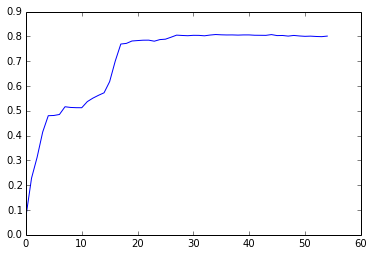

In [380]:
f_count_best = np.array(score).argmax()
print 'max score = %.4f, when use %d features' % ( np.array(score).max(), f_count_best)
X_new = SelectKBest(chi2, k=f_count_best).fit_transform(X, y)
plt.plot(score)

In [581]:
f_count_best

34

In [590]:
bestK = SelectKBest(chi2, k=55).fit(X, y)
bestK_ind = np.argsort(np.nan_to_num(bestK.scores_))[::-1]
bestK_name = X.columns[bestK_ind]

X34 = X[bestK_name[:34]]
print np.mean(sklearn.cross_validation.cross_val_score(logreg, X34,data[target],cv=4))

0.807332471747


In [418]:
from sklearn import grid_search
parameters = {'penalty':('l1','l2'), 
              'C':[0.1, 1, 10, 100]}
logreg = linear_model.LogisticRegression()
logreg_grid = grid_search.GridSearchCV(logreg, parameters, cv=4, verbose =  1)
logreg_grid.fit(X_train, y_train)
print logreg_grid.best_score_
print logreg_grid.best_estimator_
print logreg_grid.score(X_valid, y_valid)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  6.8min finished


Fitting 4 folds for each of 8 candidates, totalling 32 fits
0.80514891469
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)
0.797880393641


In [427]:
logreg_grid.fit(X_new, y)
print logreg_grid.best_score_
print logreg_grid.best_estimator_
# print logreg_grid.score(X_valid, y_valid)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  6.3min finished


Fitting 4 folds for each of 8 candidates, totalling 32 fits
0.808252886617
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)


# Stochastic gradient decent

In [424]:
# logistic
sgdc = sklearn.linear_model.SGDClassifier(loss='log') 
print sklearn.cross_validation.cross_val_score(sgdc, data[features],data[target],cv=4).mean()
# svm
sgdc = sklearn.linear_model.SGDClassifier()
print sklearn.cross_validation.cross_val_score(sgdc, data[features],data[target],cv=4).mean()

0.119211872767
0.197334126896


## SVC model

In [386]:
# LinearSVC uses one-vs-rest
lsvc = sklearn.svm.LinearSVC(C=0.01, penalty="l1", dual=False)
sklearn.cross_validation.cross_val_score(lsvc, data[features],data[target],cv=4).mean()

0.66352030938103557

In [426]:
# SVC uses one-vs-one
from sklearn import svm, grid_search
parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 
              'C':[0.1, 1, 10, 100]}
param_grid = [
  {'C':[0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C':[0.1, 1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svr = svm.SVC()
svmclf = grid_search.GridSearchCV(svr, parameters, cv=4)
svmclf.fit(X_train, y_train)
print svmclf.best_score_
print svmclf.best_estimator_
print svmclf.score(X_valid, y_valid)
# use best subset
svmclf.fit(X_new, y)
print svmclf.best_score_

0.827612317012
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.832702498107
0.841567291312


## gbm

In [428]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=4, random_state=0)
# sklearn.cross_validation.cross_val_score(gbm, data[features],data[target],cv=4).mean()
gbm.fit(X_train,y_train)
gbm.score(X_valid, y_valid)

0.015897047691143074

In [ ]:
gbm = GradientBoostingClassifier(n_estimators=1000, random_state=0)
# sklearn.cross_validation.cross_val_score(gbm, data[features],data[target],cv=4).mean()
gbm.fit(X_train,y_train)
gbm.score(X_valid, y_valid)

In [ ]:
import time
start_time = time.time()
param_grid = {'n_estimators':[100,300],
              'learning_rate':[0.1,1.0],
              'max_depth':[1,2,3,4],
              'random_state':[0]}
gbm0 = GradientBoostingClassifier()
gbm_grid = grid_search.GridSearchCV(gbm0, param_grid)
gbm_grid.fit(X_new,y)
print gbm_grid.best_score_
end_time = time.time()
print end_time-start_time

In [429]:
from sklearn.ensemble import AdaBoostClassifier
adbost = AdaBoostClassifier(n_estimators=100)
adbost.fit(X_train,y_train)
adbost.score(X_valid, y_valid)

0.24299772899318697

## rf

In [446]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
sklearn.cross_validation.cross_val_score(rf, data[features],data[target],cv=4).mean()

0.8455507028893906

In [447]:
rf

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [440]:
import time
start_time = time.time()
param_grid = {'n_estimators':[100,300,500],
#               'max_depth':[1,2,3,4],
              'random_state':[0]}
rf0 = RandomForestClassifier()
rf_grid = grid_search.GridSearchCV(rf0, param_grid, cv=4)
rf_grid.fit(X,y)
print rf_grid.best_score_
print rf_grid.best_params_
end_time = time.time()
print end_time-start_time

0.841756577702
{'n_estimators': 300, 'random_state': 0}
28.7876620293


In [441]:
import time
start_time = time.time()
param_grid = {'n_estimators':[100,300,500],
#               'max_depth':[1,2,3,4],
              'random_state':[0]}
rf0 = RandomForestClassifier()
rf_grid = grid_search.GridSearchCV(rf0, param_grid, cv=4)
rf_grid.fit(X_new,y)
print rf_grid.best_score_
print rf_grid.best_params_
end_time = time.time()
print end_time-start_time

0.848381601363
{'n_estimators': 300, 'random_state': 0}
24.1046199799


In [444]:
import time
start_time = time.time()
param_grid = {'n_estimators':[1000,2000,5000],
              'max_depth':[1,5,10,15,20],
              'random_state':[0]}
rf0 = RandomForestClassifier()
rf_grid = grid_search.GridSearchCV(rf0, param_grid, cv=4)
rf_grid.fit(X_new,y)
print rf_grid.best_score_
print rf_grid.best_params_
end_time = time.time()
print end_time-start_time

0.849895892485
{'n_estimators': 1000, 'random_state': 0, 'max_depth': 15}
727.2606709


In [445]:
import time
start_time = time.time()
param_grid = {'n_estimators':[800,900,1000,1100,1200],
              'max_depth':[12,13,14,15,16,17],
              'random_state':[0]}
rf0 = RandomForestClassifier()
rf_grid = grid_search.GridSearchCV(rf0, param_grid, cv=4)
rf_grid.fit(X_new,y)
print rf_grid.best_score_
print rf_grid.best_params_
end_time = time.time()
print end_time-start_time

0.850274465266
{'n_estimators': 1000, 'random_state': 0, 'max_depth': 13}
718.757955074


0.840664182122


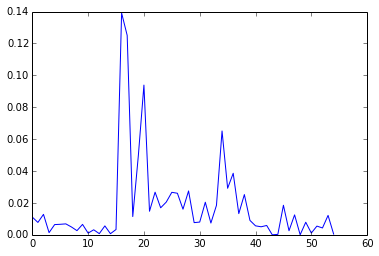

In [454]:
# fit rf with all 55 features 
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
print sklearn.cross_validation.cross_val_score(rf, X,y,cv=4).mean()
rf.fit(X,y)
plt.plot(rf.feature_importances_)

In [485]:
# feature selection by rf.feature_importances_. Select from original 55 features
score = []
for feature_cut in np.linspace(0.00,0.02,21):
    selected_features = X.columns[rf.feature_importances_>feature_cut]
    X_selected = X[selected_features]
    rf1 = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
    score.append(sklearn.cross_validation.cross_val_score(rf1, X_selected,y,cv=4).mean())
    print feature_cut, len(selected_features), score[-1]
    # rf1.fit(X_selected,y)
    # plt.plot(rf1.feature_importances_)

0.0 54 0.838944010386
0.001 49 0.845391305789
0.002 46 0.840657950627
0.003 44 0.840086752277
0.004 42 0.843493447339
0.005 40 0.844828681732
0.006 35 0.842965233151
0.007 31 0.847508926145
0.008 26 0.852039751906
0.009 26 0.852039751906
0.01 25 0.855638374435
0.011 25 0.855638374435
0.012 23 0.849935159573
0.013 20 0.853524964356
0.014 19 0.843488560154
0.015 18 0.843294919768
0.016 18 0.843294919768
0.017 16 0.84386174768
0.018 16 0.84386174768
0.019 14 0.828146567059
0.02 14 0.828146567059


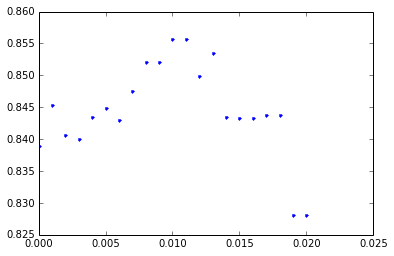

In [486]:
plt.plot(np.linspace(0.00,0.02,21), score, 'b.')

0.850304221372


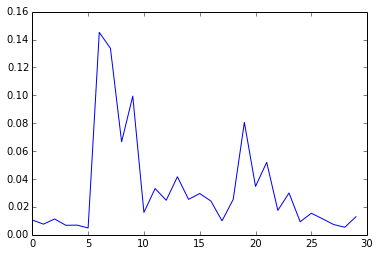

In [487]:
# fit rf with features selected by best_feature(chi2, n=34)
rf_new = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
print sklearn.cross_validation.cross_val_score(rf_new, X_new,y,cv=4).mean()
rf_new.fit(X_new,y)
plt.plot(rf_new.feature_importances_)

In [516]:
# feature selection by rf.feature_importances_. Select from 34 features that were selected by best_feature(chi2, n=34)
score_new = []
for feature_cut in np.linspace(0.004,0.018,15):
    X_selected = X_new[:,rf_new.feature_importances_>=feature_cut]
    rf1 = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
    score_new.append(sklearn.cross_validation.cross_val_score(rf1, X_selected,y,cv=4).mean())
    print feature_cut, X_selected.shape[1], score[-1]
    # rf1.fit(X_selected,y)
    # plt.plot(rf1.feature_importances_)

0.004 30 0.850304221372
0.005 29 0.847276166684
0.006 28 0.850884986903
0.007 26 0.849930384891
0.008 24 0.847647315175
0.009 24 0.847647315175
0.01 23 0.84748163955
0.011 21 0.849350380189
0.012 19 0.850497878946
0.013 18 0.85179715197
0.014 18 0.85179715197
0.015 18 0.85179715197
0.016 17 0.852377513257
0.017 16 0.855585502141
0.018 15 0.837614246659


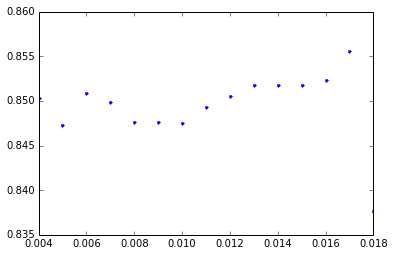

In [521]:
plt.plot(np.linspace(0.004,0.018,15), score_new, 'b.')

 1 0.481523616027
2 0.476865841496
3 0.482164616043
4 0.543672581775
5 0.546877365922
6 0.547060617987
7 0.547638291914
8 0.552558913621
9 0.550869863096
10 0.553140439982
11 0.582833653716
12 0.618263403348
13 0.625792102022
14 0.620754889397
15 0.661380356348
16 0.74372535325
17 0.811120446887
18 0.809998177245
19 0.826060913292
20 0.825878760825
21 0.824551505852
22 0.823783426745
23 0.82265018656
24 0.829648368855
25 0.830799298612
26 0.838509905043
27 0.851787911534
28 0.851047523266
29 0.851042879533
30 0.850304221372
31 0.845566935649
32 0.843661763296
33 0.844995409925
34 0.846349546621
35 0.844260670301
36 0.851462707859
37 0.849022441496
38 0.846722800251
39 0.846902960712
40 0.846894981293
41 0.846329818013
42 0.844060067432
43 0.845205187756
44 0.843684952746
45 0.842556843829
46 0.84104017077
47 0.83895024188
48 0.838181627581
49 0.844450897502
50 0.843492995438
51 0.842177311675
52 0.84178789076
53 0.840473776942
54 0.838944010386
[0.48152361602657234, 0.47686584149631173

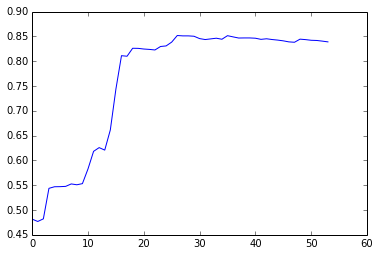

In [525]:
# feature selection by best_feature(chi2, n=i)
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
score_rf=[]
for i in range(1,X.shape[1]):
    X_new_rf = SelectKBest(chi2, k=i).fit_transform(X, y)
    score_rf.append(np.mean(sklearn.cross_validation.cross_val_score(rf, X_new_rf,y,cv=4)))
    print i, score_rf[-1]

f_count_best_rf = np.array(score_rf).argmax()+1
X_new_rf = SelectKBest(chi2, k=f_count_best_rf).fit_transform(X, y)
print score_rf
print 'max score = %.4f, when use %d features' % ( np.array(score_rf).max(), f_count_best_rf)
plt.plot(score_rf)

In [563]:
bestK = SelectKBest(chi2, k=55).fit(X, y)
bestK_ind = np.argsort(np.nan_to_num(bestK.scores_))[::-1]
bestK_name = X.columns[bestK_ind]
print bestK_name
print bestK_name.shape

Index([u'DISTRICT', u'tribe', u'REGION_PROVINCE', u'babydoc', u'foodinsecurity', u'religion_Buddhist', u'india', u'hindu', u'religion_Hindu', u'religion_Russian/Easter', u'educ', u'Debut', u'literacy', u'christian', u'hivknow', u'ModCon', u'age', u'thrasher', u'usecondom', u'religion_Other Christia', u'religion_Muslim', u'muslim', u'lowlit', u'multpart', u'motorcycle', u'CHILDREN', u'LaborDeliv', u'furniture', u'married', u'urbanicity', u'generator', u'cart', u'EVER_BEEN_PREGNANT', u'EVER_HAD_SEX', u'inschool', u'religion_Roman Catholic', u'cooker', u'radio', u'irrigation', u'highlit', u'religion_Evangelical/Bo', u'religion_Traditional/An', u'fridge', u'urban', u'other', u'religion_Other', u'ownincome', u'rural', u'electricity', u'cellphone', u'computer', u'car', u'religion_nan', u'religion_Jewish', u'single'], dtype='object')
(55,)


In [18]:
bestK = SelectKBest(chi2, k=55).fit(X, y)
bestK_ind = np.argsort(np.nan_to_num(bestK.scores_))[::-1]
bestK_name = X.columns[bestK_ind]

X27 = X[bestK_name[:27]]
X30 = X[bestK_name[:30]]
X34 = X[bestK_name[:34]]

In [573]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
print sklearn.cross_validation.cross_val_score(rf, X27,y,cv=4).mean()
print sklearn.cross_validation.cross_val_score(rf, X30,y,cv=4).mean()
print sklearn.cross_validation.cross_val_score(rf, X34,y,cv=4).mean()

0.851802866088
0.848417208309
0.845559181867


In [575]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
rf.fit(X,y)
feature_cut=0.011
selected_features = X.columns[rf.feature_importances_>feature_cut]
print selected_features.shape
print sklearn.cross_validation.cross_val_score(rf, X[selected_features],y,cv=4).mean()

(25,)
0.855638374435


In [598]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
rf.fit(X30,y)
feature_cut=0.017
X_selected = X30[X30.columns[rf.feature_importances_>feature_cut]]
print X_selected.shape
print sklearn.cross_validation.cross_val_score(rf, X_selected,y,cv=4).mean()

(5283, 16)
0.855408594075


In [602]:
rf2 = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0).fit(X,y)
rf3 = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0).fit(X30,y)

In [603]:
selection1 = bestK_name[:27]
selection2 = X.columns[rf2.feature_importances_>0.011]
selection3 = X30.columns[rf3.feature_importances_>0.017]

In [604]:
print "\nbest columns by BestK, n_col=27:\n", selection1
print "\nbest columns by feature_importances_, n_col=25:\n", selection2
print "\nbest columns by first Best30 then feature_importances_, n_col=16:\n", selection3


best columns by BestK, n_col=27:
Index([u'DISTRICT', u'tribe', u'REGION_PROVINCE', u'babydoc', u'foodinsecurity', u'religion_Buddhist', u'india', u'hindu', u'religion_Hindu', u'religion_Russian/Easter', u'educ', u'Debut', u'literacy', u'christian', u'hivknow', u'ModCon', u'age', u'thrasher', u'usecondom', u'religion_Other Christia', u'religion_Muslim', u'muslim', u'lowlit', u'multpart', u'motorcycle', u'CHILDREN', u'LaborDeliv'], dtype='object')

best columns by feature_importances_, n_col=25:
Index([u'christian', u'hindu', u'REGION_PROVINCE', u'DISTRICT', u'electricity', u'age', u'tribe', u'foodinsecurity', u'EVER_HAD_SEX', u'EVER_BEEN_PREGNANT', u'CHILDREN', u'india', u'married', u'multpart', u'educ', u'literacy', u'LaborDeliv', u'babydoc', u'Debut', u'ModCon', u'usecondom', u'hivknow', u'religion_Buddhist', u'religion_Hindu', u'religion_Russian/Easter'], dtype='object')

best columns by first Best30 then feature_importances_, n_col=16:
Index([u'DISTRICT', u'tribe', u'REGION_PROVINC

In [607]:
all_selection = set(list(selection1)+list(selection2)+list(selection3))
print len(all_selection)
D={}
for c in all_selection:
    key = (c in selection1, c in selection2, c in selection3)
    colection = D.get(key,[])
    D[key] = colection+[c]

31


In [608]:
D

{(False, True, False): ['electricity', 'EVER_HAD_SEX', 'EVER_BEEN_PREGNANT'],
 (False, True, True): ['married'],
 (True, False, False): ['religion_Other Christia',
  'religion_Muslim',
  'muslim',
  'lowlit',
  'thrasher',
  'motorcycle'],
 (True, True, False): ['foodinsecurity',
  'religion_Buddhist',
  'religion_Russian/Easter',
  'hindu',
  'christian',
  'religion_Hindu'],
 (True, True, True): ['tribe',
  'india',
  'multpart',
  'babydoc',
  'ModCon',
  'usecondom',
  'Debut',
  'LaborDeliv',
  'hivknow',
  'REGION_PROVINCE',
  'educ',
  'CHILDREN',
  'literacy',
  'DISTRICT',
  'age']}

In [610]:
slection_combined = list(selection1)+list(selection2)+list(selection3)
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
X_selected = X[slection_combined]
print X_selected.shape
print sklearn.cross_validation.cross_val_score(rf, X_selected,y,cv=4).mean()

(5283, 68)
0.864127679723


(5283, 68)
0.0 68 0.864127679723
0.001 68 0.864127679723
0.002 65 0.863967117549
0.003 59 0.861875148996
0.004 52 0.862236296222
0.005 49 0.860713278536
0.006 49 0.860713278536
0.007 49 0.860713278536
0.008 37 0.839094833193
0.009 34 0.824521080624
0.01 34 0.824521080624
0.011 31 0.824526259549
0.012 21 0.778759262985
0.013 21 0.778759262985
0.014 21 0.778759262985
0.015 21 0.778759262985
0.016 19 0.76868398316
0.017 19 0.76868398316
0.018 19 0.76868398316
0.019 19 0.76868398316
0.02 19 0.76868398316
[0.86412767972276017, 0.86412767972276017, 0.86396711754884314, 0.86187514899569029, 0.86223629622168729, 0.86071327853580459, 0.86071327853580459, 0.86071327853580459, 0.83909483319322042, 0.82452108062382767, 0.82452108062382767, 0.8245262595493984, 0.778759262984696, 0.778759262984696, 0.778759262984696, 0.778759262984696, 0.76868398316023623, 0.76868398316023623, 0.76868398316023623, 0.76868398316023623, 0.76868398316023623]


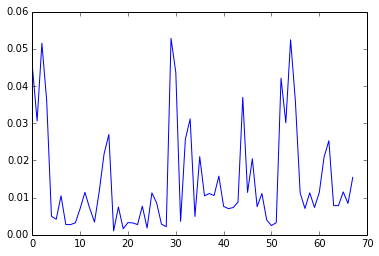

In [628]:
slection_combined = list(selection1)+list(selection2)+list(selection3)
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
X_selected_combined = X[slection_combined]
rf.fit(X_selected_combined,y)
print X_selected_combined.shape
plt.plot(rf.feature_importances_)

score_new = []
rf1 = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
for feature_cut in np.linspace(0.000,0.020,21):
    X_selected = X_selected_combined.ix[:,rf.feature_importances_>=feature_cut]
    score_new.append(sklearn.cross_validation.cross_val_score(rf1, X_selected,y,cv=4).mean())
    print feature_cut, X_selected.shape[1], score_new[-1]
    # rf1.fit(X_selected,y)
    # plt.plot(rf1.feature_importances_)
print score_new

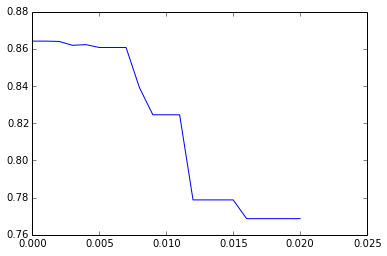

In [629]:
plt.plot(np.linspace(0.000,0.020,21),score_new)

In [634]:
selection_combined = list(selection1)+list(selection2)+list(selection3)
selection_combined_i = [selection_combined[i]+str(i) for i in range(len(selection_combined))]
zip(selection_combined, selection_combined_i)

[('DISTRICT', 'DISTRICT0'),
 ('tribe', 'tribe1'),
 ('REGION_PROVINCE', 'REGION_PROVINCE2'),
 ('babydoc', 'babydoc3'),
 ('foodinsecurity', 'foodinsecurity4'),
 ('religion_Buddhist', 'religion_Buddhist5'),
 ('india', 'india6'),
 ('hindu', 'hindu7'),
 ('religion_Hindu', 'religion_Hindu8'),
 ('religion_Russian/Easter', 'religion_Russian/Easter9'),
 ('educ', 'educ10'),
 ('Debut', 'Debut11'),
 ('literacy', 'literacy12'),
 ('christian', 'christian13'),
 ('hivknow', 'hivknow14'),
 ('ModCon', 'ModCon15'),
 ('age', 'age16'),
 ('thrasher', 'thrasher17'),
 ('usecondom', 'usecondom18'),
 ('religion_Other Christia', 'religion_Other Christia19'),
 ('religion_Muslim', 'religion_Muslim20'),
 ('muslim', 'muslim21'),
 ('lowlit', 'lowlit22'),
 ('multpart', 'multpart23'),
 ('motorcycle', 'motorcycle24'),
 ('CHILDREN', 'CHILDREN25'),
 ('LaborDeliv', 'LaborDeliv26'),
 ('christian', 'christian27'),
 ('hindu', 'hindu28'),
 ('REGION_PROVINCE', 'REGION_PROVINCE29'),
 ('DISTRICT', 'DISTRICT30'),
 ('electricity', 

In [635]:
selection_combined_i

['DISTRICT0',
 'tribe1',
 'REGION_PROVINCE2',
 'babydoc3',
 'foodinsecurity4',
 'religion_Buddhist5',
 'india6',
 'hindu7',
 'religion_Hindu8',
 'religion_Russian/Easter9',
 'educ10',
 'Debut11',
 'literacy12',
 'christian13',
 'hivknow14',
 'ModCon15',
 'age16',
 'thrasher17',
 'usecondom18',
 'religion_Other Christia19',
 'religion_Muslim20',
 'muslim21',
 'lowlit22',
 'multpart23',
 'motorcycle24',
 'CHILDREN25',
 'LaborDeliv26',
 'christian27',
 'hindu28',
 'REGION_PROVINCE29',
 'DISTRICT30',
 'electricity31',
 'age32',
 'tribe33',
 'foodinsecurity34',
 'EVER_HAD_SEX35',
 'EVER_BEEN_PREGNANT36',
 'CHILDREN37',
 'india38',
 'married39',
 'multpart40',
 'educ41',
 'literacy42',
 'LaborDeliv43',
 'babydoc44',
 'Debut45',
 'ModCon46',
 'usecondom47',
 'hivknow48',
 'religion_Buddhist49',
 'religion_Hindu50',
 'religion_Russian/Easter51',
 'DISTRICT52',
 'tribe53',
 'REGION_PROVINCE54',
 'babydoc55',
 'india56',
 'educ57',
 'Debut58',
 'literacy59',
 'hivknow60',
 'ModCon61',
 'age62',


In [638]:
print list(selection1)
print list(selection2)
print list(selection3)

['DISTRICT', 'tribe', 'REGION_PROVINCE', 'babydoc', 'foodinsecurity', 'religion_Buddhist', 'india', 'hindu', 'religion_Hindu', 'religion_Russian/Easter', 'educ', 'Debut', 'literacy', 'christian', 'hivknow', 'ModCon', 'age', 'thrasher', 'usecondom', 'religion_Other Christia', 'religion_Muslim', 'muslim', 'lowlit', 'multpart', 'motorcycle', 'CHILDREN', 'LaborDeliv']
['christian', 'hindu', 'REGION_PROVINCE', 'DISTRICT', 'electricity', 'age', 'tribe', 'foodinsecurity', 'EVER_HAD_SEX', 'EVER_BEEN_PREGNANT', 'CHILDREN', 'india', 'married', 'multpart', 'educ', 'literacy', 'LaborDeliv', 'babydoc', 'Debut', 'ModCon', 'usecondom', 'hivknow', 'religion_Buddhist', 'religion_Hindu', 'religion_Russian/Easter']
['DISTRICT', 'tribe', 'REGION_PROVINCE', 'babydoc', 'india', 'educ', 'Debut', 'literacy', 'hivknow', 'ModCon', 'age', 'usecondom', 'multpart', 'CHILDREN', 'LaborDeliv', 'married']


In [641]:
print [list(selection1)[i]+str(i) for i in range(len(selection1))]
print [list(selection2)[i]+str(len(selection1)+i) for i in range(len(selection2))]
print [list(selection3)[i]+str(len(selection1)+len(selection2)+i) for i in range(len(selection3))]

['DISTRICT0', 'tribe1', 'REGION_PROVINCE2', 'babydoc3', 'foodinsecurity4', 'religion_Buddhist5', 'india6', 'hindu7', 'religion_Hindu8', 'religion_Russian/Easter9', 'educ10', 'Debut11', 'literacy12', 'christian13', 'hivknow14', 'ModCon15', 'age16', 'thrasher17', 'usecondom18', 'religion_Other Christia19', 'religion_Muslim20', 'muslim21', 'lowlit22', 'multpart23', 'motorcycle24', 'CHILDREN25', 'LaborDeliv26']
['christian27', 'hindu28', 'REGION_PROVINCE29', 'DISTRICT30', 'electricity31', 'age32', 'tribe33', 'foodinsecurity34', 'EVER_HAD_SEX35', 'EVER_BEEN_PREGNANT36', 'CHILDREN37', 'india38', 'married39', 'multpart40', 'educ41', 'literacy42', 'LaborDeliv43', 'babydoc44', 'Debut45', 'ModCon46', 'usecondom47', 'hivknow48', 'religion_Buddhist49', 'religion_Hindu50', 'religion_Russian/Easter51']
['DISTRICT52', 'tribe53', 'REGION_PROVINCE54', 'babydoc55', 'india56', 'educ57', 'Debut58', 'literacy59', 'hivknow60', 'ModCon61', 'age62', 'usecondom63', 'multpart64', 'CHILDREN65', 'LaborDeliv66', '

In [648]:
# used for R df column selection
selection_combined_religon = [c for c in selection_combined if c[:8]!='religion'] + ['religion','religion']
print len(selection_combined_religon)
print selection_combined_religon
selection_combined_religon_i = [selection_combined_religon[i]+str(i) for i in range(len(selection_combined_religon))]
print selection_combined_religon_i

62
['DISTRICT', 'tribe', 'REGION_PROVINCE', 'babydoc', 'foodinsecurity', 'india', 'hindu', 'educ', 'Debut', 'literacy', 'christian', 'hivknow', 'ModCon', 'age', 'thrasher', 'usecondom', 'muslim', 'lowlit', 'multpart', 'motorcycle', 'CHILDREN', 'LaborDeliv', 'christian', 'hindu', 'REGION_PROVINCE', 'DISTRICT', 'electricity', 'age', 'tribe', 'foodinsecurity', 'EVER_HAD_SEX', 'EVER_BEEN_PREGNANT', 'CHILDREN', 'india', 'married', 'multpart', 'educ', 'literacy', 'LaborDeliv', 'babydoc', 'Debut', 'ModCon', 'usecondom', 'hivknow', 'DISTRICT', 'tribe', 'REGION_PROVINCE', 'babydoc', 'india', 'educ', 'Debut', 'literacy', 'hivknow', 'ModCon', 'age', 'usecondom', 'multpart', 'CHILDREN', 'LaborDeliv', 'married', 'religion', 'religion']
['DISTRICT0', 'tribe1', 'REGION_PROVINCE2', 'babydoc3', 'foodinsecurity4', 'india5', 'hindu6', 'educ7', 'Debut8', 'literacy9', 'christian10', 'hivknow11', 'ModCon12', 'age13', 'thrasher14', 'usecondom15', 'muslim16', 'lowlit17', 'multpart18', 'motorcycle19', 'CHILDRE

### consider subgroup of y labels

In [649]:
slection_combined = list(selection1)+list(selection2)+list(selection3)
selection_combined_i = [selection_combined[i]+str(i) for i in range(len(selection_combined))]
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
X_selected = X[slection_combined]
X_selected.columns=selection_combined_i
print X_selected.shape
print sklearn.cross_validation.cross_val_score(rf, X_selected,y,cv=4).mean()

(5283, 68)
0.864127679723


In [652]:
X68_train,X68_valid,y68_train,y68_valid = sklearn.cross_validation.train_test_split(X_selected,y,test_size=0.25, random_state=42)

In [657]:
rf.fit(X68_train,y68_train)
y68_pred = rf.predict(X68_valid)

In [655]:
sklearn.metrics.accuracy_score(y68_valid,y68_pred)

0.85995457986373958

In [684]:
conf_mat = sklearn.metrics.confusion_matrix(y68_valid, y68_pred,labels=sorted(y.unique()))
recall_mat = (1.0*conf_mat/conf_mat.sum(axis=1))

[111, 121, 122, 211, 212, 221, 222, 231, 241, 311, 312, 321, 322, 411, 412]


In [716]:
y68_valid_geo = y68_valid/100
y68_pred_geo = y68_pred/100
print sklearn.metrics.confusion_matrix(y68_valid_geo, y68_pred_geo)

[[168   0   0   0   0   0   0   0   0]
 [  0 158   0   0   0   0   0   0   0]
 [  0   0 143   0   0   0   0   0   0]
 [  0   0   0  88   0   0   0   0   0]
 [  0   0   0   0 166   0   0   0   0]
 [  0   0   0   0   0 133   0   0   0]
 [  0   0   0   0   0   0 161   0   0]
 [  0   0   0   0   0   0   0 150   0]
 [  0   0   0   0   0   0   0   0 154]]


In [754]:
geos=list(set([int(yy/100) for yy in y]))
for geo in geos:
    y68_valid_geo_i = y68_valid[y68_valid_geo==geo]
    y68_pred_geo_i = y68_pred[y68_pred_geo==geo]
    print "\ngeo = ", geo
    print sklearn.metrics.confusion_matrix(y68_valid_geo_i, y68_pred_geo_i)


geo =  1
[[60  0  0]
 [ 0 96  1]
 [ 0 11  0]]

geo =  2
[[23  0  8  0  9  0]
 [ 2  6  0  1  1  5]
 [ 2  0 29  0  2  0]
 [ 0  1  0  2  0  4]
 [ 3  0  3  1 39  1]
 [ 0  0  1  2  1 12]]

geo =  3
[[75  0  2  0]
 [ 0 36  0  0]
 [ 1  0 15  0]
 [ 0  1  2 11]]

geo =  4
[[73  2]
 [ 2 11]]

geo =  5
[[12  3  0  4  1]
 [ 1 16  5  1  0]
 [ 0  7 27  3  5]
 [ 0  0  3 30 11]
 [ 0  0 12  5 20]]

geo =  6
[[38  1  0]
 [ 3 19  0]
 [ 2  0 70]]

geo =  7
[[16  3  1  0  0]
 [ 3 19  5  0  3]
 [ 0  6 33  1  0]
 [ 0  1  0 21  0]
 [ 0  1  1  0 47]]

geo =  8
[[26  5  0  1]
 [ 1 55  1  0]
 [ 1  0 39  1]
 [ 0  1  1 18]]

geo =  9
[[12  0  1  3  0]
 [ 0  2  0  4  0]
 [ 0  1 61  0  0]
 [ 3  0  0 57  0]
 [ 0  0  0  0 10]]


In [12]:
def split_by_geo(X,y):
    geos = range(1,10)
    X_res, y_res = {}, {}
    for geo in geos:
        X_res[geo] = X[y/100==geo,:]
        y_res[geo] = y[y/100==geo]
    return X_res, y_res

In [823]:
type(y.values)

numpy.ndarray

In [829]:
X_train_geo_split, y_train_geo_split = split_by_geo(X68_train,y68_train)
X_valid_geo_split, y_valid_geo_split = split_by_geo(X68_valid,y68_valid)
X_selected
X_selected_geo_split, y_selected_geo_split = split_by_geo(X_selected.values,y.values)


In [13]:
X_geo_split, y_geo_split = split_by_geo(X.values,y.values)

In [826]:
for i in range(1,10):
    print i,X_train_geo_split[i].shape[0],X_valid_geo_split[i].shape[0], X_selected_geo_split[i].shape[0]

1 446 168 614
2 465 158 623
3 460 143 603
4 300 88 388
5 459 166 625
6 468 133 601
7 450 161 611
8 467 150 617
9 447 154 601


In [827]:
# use selected features
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
for i in range(1,10):
    print i, sklearn.cross_validation.cross_val_score(rf, X_selected_geo_split[i],y_selected_geo_split[i],cv=4).mean()

1 0.916928053055
2 0.749908927262
3 0.97509758036
4 0.966465806683
5 0.61713235723
6 0.960143191549
7 0.809981910847
8 0.917455432937
9 0.921823924201


In [831]:
# use all original features
rf = RandomForestClassifier(n_estimators=1000, max_depth=13, random_state=0)
for i in range(1,10):
    print i, sklearn.cross_validation.cross_val_score(rf, X_geo_split[i],y_geo_split[i],cv=4).mean()

1 0.916991996804
2 0.741936675492
3 0.965184858118
4 0.920205550004
5 0.623758836101
6 0.955154229077
7 0.795531119169
8 0.893134550085
9 0.876927885248


In [832]:
X_geo_5, y_geo_5 = X_geo_split[5], y_geo_split[5]

# logistic for X_geo_5

In [837]:
# logistic
from sklearn import grid_search
parameters = {'penalty':('l1','l2'), 
              'C':[0.1, 1, 10, 100]}
logreg = linear_model.LogisticRegression()
logreg_grid = grid_search.GridSearchCV(logreg, parameters, cv=5)
logreg_grid.fit(X_geo_5, y_geo_5)
print logreg_grid.best_score_
print logreg_grid.best_estimator_


0.5616
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)


### SVC for X_geo_5

In [838]:
# SVC uses one-vs-one
from sklearn import svm, grid_search
parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 
              'C':[0.1, 1, 10, 100]}
param_grid = [
  {'C':[0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C':[0.1, 1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svr = svm.SVC()
svmclf = grid_search.GridSearchCV(svr, parameters, cv=4)
svmclf.fit(X_geo_5, y_geo_5)
print svmclf.best_score_
print svmclf.best_estimator_


0.5872
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


### rf for X_geo_5

In [833]:
# search for parameters
start_time = time.time()
param_grid = {'n_estimators':[800,900,1000,1100,1200],
              'max_depth':[12,13,14,15,16,17],
              'random_state':[0]}
rf0 = RandomForestClassifier()
rf_grid = grid_search.GridSearchCV(rf0, param_grid, cv=4)
rf_grid.fit(X_geo_5,y_geo_5)
print rf_grid.best_score_
print rf_grid.best_params_
end_time = time.time()
print end_time-start_time

0.6272
{'n_estimators': 800, 'random_state': 0, 'max_depth': 12}
131.44304204


In [883]:
# search for parameters
start_time = time.time()
param_grid = {'n_estimators':[100,150,200,250,300,400,1000,2000],
              'max_depth':[1,2,4,6,8,10,15],
              'random_state':[0]}
rf0 = RandomForestClassifier()
rf_grid = grid_search.GridSearchCV(rf0, param_grid, cv=4)
rf_grid.fit(X_geo_5,y_geo_5)
print rf_grid.best_score_
print rf_grid.best_params_
end_time = time.time()
print end_time-start_time

0.6288
{'n_estimators': 200, 'random_state': 0, 'max_depth': 8}
116.556493998


0.0 55 0.628597545778
0.001 41 0.615754774013
0.002 39 0.609467553679
0.003 38 0.620594279139
0.004 36 0.610833868051
0.005 36 0.610833868051
0.006 35 0.617265329607
0.007 35 0.617265329607
0.008 35 0.617265329607
0.009 32 0.606251425178
0.01 31 0.617440195574
0.011 30 0.603097341613
0.012 30 0.603097341613
0.013 27 0.604535378872
0.014 23 0.604443504637
0.015 21 0.61067027093
0.016 20 0.596337094918
0.017 20 0.596337094918
0.018 18 0.615632275034
0.019 18 0.615632275034
0.02 18 0.615632275034
[0.62859754577802762, 0.61575477401324685, 0.60946755367947691, 0.620594279138583, 0.61083386805109963, 0.61083386805109963, 0.61726532960710179, 0.61726532960710179, 0.61726532960710179, 0.6062514251775174, 0.61744019557412777, 0.60309734161306228, 0.60309734161306228, 0.60453537887184272, 0.60444350463746144, 0.61067027092956039, 0.59633709491814846, 0.59633709491814846, 0.6156322750340717, 0.6156322750340717, 0.6156322750340717]


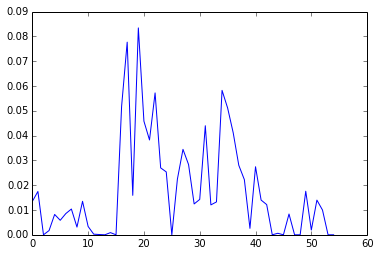

In [846]:
# Feature selection by feature_importances_
rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0)
# print i, sklearn.cross_validation.cross_val_score(rf, X_geo_split[i],y_geo_split[i],cv=4).mean()
rf.fit(X_geo_5,y_geo_5)
plt.plot(rf.feature_importances_)

score_new = []
rf1 = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0)
for feature_cut in np.linspace(0.000,0.020,21):
    X_selected = X_geo_5[:,rf.feature_importances_>=feature_cut]
    score_new.append(sklearn.cross_validation.cross_val_score(rf1, X_selected,y_geo_5,cv=4).mean())
    print feature_cut, X_selected.shape[1], score_new[-1]
    # rf1.fit(X_selected,y)
    # plt.plot(rf1.feature_importances_)
print score_new

In [850]:
rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0)
print sklearn.cross_validation.cross_val_score(rf, X_geo_5,y_geo_5,cv=4).mean()
rf.fit(X_geo_5,y_geo_5)

0.628597545778


RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=0, verbose=0)

In [860]:
for cut in [0.01, 0.015, 0.02,0.08,0.09,0.1]:
    X_try = np.concatenate((X_geo_5,X_geo_5[:,rf.feature_importances_>=cut]), axis=1)
    print cut, sklearn.cross_validation.cross_val_score(rf, X_try,y_geo_5,cv=4).mean()

0.01 0.606107979403
0.015 0.609385357395
0.02 0.606210327035
0.08 0.609548954516
0.09 0.628597545778
0.1 0.628597545778


In [886]:
y_geo_5_seg = y_geo_5/10
rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0)
print sklearn.cross_validation.cross_val_score(rf, X_geo_5,y_geo_5_seg,cv=4).mean()

0.77119632217


In [887]:
# search for parameters
start_time = time.time()
param_grid = {'n_estimators':[100,200,500,800,1000,],
              'max_depth':[1,2,4,6,8,10,12],
              'random_state':[0]}
rf0 = RandomForestClassifier()
rf_grid = grid_search.GridSearchCV(rf0, param_grid, cv=4)
rf_grid.fit(X_geo_5,y_geo_5_seg)
print rf_grid.best_score_
print rf_grid.best_params_
end_time = time.time()
print end_time-start_time

0.7872
{'n_estimators': 500, 'random_state': 0, 'max_depth': 12}
144.987279892


In [890]:
np.unique(y_geo_5_seg)

array([51, 52, 53])

In [894]:
ind_geo_51 = y_geo_5_seg ==51
X_geo_51 = X_geo_5[ind_geo_51,:]
y_geo_51 = y_geo_5[ind_geo_51]
print X_geo_51.shape,y_geo_51.shape

# search for parameters
start_time = time.time()
param_grid = {'n_estimators':[100,200,500,800,1000,],
              'max_depth':[1,2,4,6,8,10,12],
              'random_state':[0]}
rf0 = RandomForestClassifier()
rf_grid = grid_search.GridSearchCV(rf0, param_grid, cv=4)
rf_grid.fit(X_geo_51,y_geo_51)
print rf_grid.best_score_
print rf_grid.best_params_
end_time = time.time()
print end_time-start_time

(168, 55) (168,)
0.744047619048
{'n_estimators': 100, 'random_state': 0, 'max_depth': 8}
44.8232941628


In [895]:
ind_geo_53 = y_geo_5_seg ==53
X_geo_53 = X_geo_5[ind_geo_53,:]
y_geo_53 = y_geo_5[ind_geo_53]
print X_geo_53.shape,y_geo_53.shape

# search for parameters
start_time = time.time()
param_grid = {'n_estimators':[100,200,500,800,1000,],
              'max_depth':[1,2,4,6,8,10,12],
              'random_state':[0]}
rf0 = RandomForestClassifier()
rf_grid = grid_search.GridSearchCV(rf0, param_grid, cv=4)
rf_grid.fit(X_geo_53,y_geo_53)
print rf_grid.best_score_
print rf_grid.best_params_
end_time = time.time()
print end_time-start_time

(290, 55) (290,)
0.789655172414
{'n_estimators': 500, 'random_state': 0, 'max_depth': 12}
49.048530817


In [912]:
# use different model for segment and subgroup

X_5_train, X_5_valid, y_5_train, y_5_valid = sklearn.cross_validation.train_test_split(X_geo_5,y_geo_5, test_size=0.1, random_state=42)
def train_geo_5(X_5_train, y_5_train):
    X_5_train_51 = X_5_train[y_5_train/10 == 51]
    y_5_train_51 = y_5_train[y_5_train/10 == 51]
    X_5_train_53 = X_5_train[y_5_train/10 == 53]
    y_5_train_53 = y_5_train[y_5_train/10 == 53]
#     rf0 = RandomForestClassifier(   n_estimators=500, max_depth=12, random_state=0).fit(X_5_train,   y_5_train)
    rf1_51 = RandomForestClassifier(n_estimators=100, max_depth=8,  random_state=0).fit(X_5_train_51,y_5_train_51)
    rf1_53 = RandomForestClassifier(n_estimators=500, max_depth=12, random_state=0).fit(X_5_train_53,y_5_train_53)
    rf0 = GradientBoostingClassifier(n_estimators=1000, learning_rate=.01,max_depth=2, random_state=0).fit(X_5_train,   y_5_train)
#     rf1_51 = GradientBoostingClassifier(n_estimators=1000, learning_rate=.01,max_depth=2, random_state=0).fit(X_5_train_51,y_5_train_51)
#     rf1_53 = GradientBoostingClassifier(n_estimators=1000, learning_rate=.01,max_depth=2, random_state=0).fit(X_5_train_53,y_5_train_53)
    model = [rf0, rf1_51, rf1_53]
    return model
def predict_geo_5(model, X_5_valid):
    rf0, rf1_51, rf1_53 = model
    y_5_pred = rf0.predict(X_5_valid)
    ind_pred_51 = y_5_pred/10 == 51
    ind_pred_53 = y_5_pred/10 == 53
    
    X_5_pred_51 = X_5_valid[ind_pred_51]
    X_5_pred_53 = X_5_valid[ind_pred_53]

    y_5_pred[ind_pred_51] = rf1_51.predict(X_5_pred_51)
    y_5_pred[ind_pred_53] = rf1_53.predict(X_5_pred_53)
    
    return y_5_pred

model = train_geo_5(X_5_train, y_5_train)
y_5_pred = predict_geo_5(model, X_5_valid)
print sklearn.metrics.accuracy_score(y_5_valid, y_5_pred)

0.650793650794


### gbm on X_geo_5

In [862]:
gbm = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0,max_depth=4, random_state=0)
sklearn.cross_validation.cross_val_score(gbm, X_geo_5,y_geo_5,cv=4).mean()

0.60431053226071607

In [863]:
import time
start_time = time.time()
param_grid = {'n_estimators':[1000,3000],
              'learning_rate':[0.1,1.0],
              'max_depth':[1,5,10,15],
              'random_state':[0]}
gbm0 = GradientBoostingClassifier()
gbm_grid = grid_search.GridSearchCV(gbm0, param_grid)
gbm_grid.fit(X_geo_5,y_geo_5)
print gbm_grid.best_score_
print gbm_grid.best_params_
end_time = time.time()
print end_time-start_time

0.6096
{'n_estimators': 1000, 'learning_rate': 0.1, 'random_state': 0, 'max_depth': 5}
284.979890108


In [864]:
gbm.fit(X_geo_5,y_geo_5)
sklearn.metrics.confusion_matrix(gbm.predict(X_geo_5),y_geo_5)

array([[ 74,   0,   0,   0,   0],
       [  0,  94,   0,   0,   0],
       [  0,   0, 167,   0,   0],
       [  0,   0,   0, 134,   0],
       [  0,   0,   0,   0, 156]])

In [865]:
gbm.score(X_geo_5,y_geo_5)

1.0

In [870]:
for ntree in [100,200,500,700,1000]:
    gbm = GradientBoostingClassifier(n_estimators=ntree, learning_rate=.1,max_depth=5, random_state=0)
    gbm.fit(X_train_geo_split[5],y_train_geo_split[5])
    # print sklearn.metrics.confusion_matrix(gbm.predict(X_valid_geo_split[5]),y_valid_geo_split[5])
    print gbm.score(X_valid_geo_split[5],y_valid_geo_split[5]), gbm.score(X_train_geo_split[5],y_train_geo_split[5])

0.650602409639 1.0
0.632530120482 1.0
0.632530120482 1.0
0.632530120482 1.0
0.632530120482 1.0


In [874]:
for ntree in [100,200,300]:
    gbm = GradientBoostingClassifier(n_estimators=ntree, learning_rate=.01,max_depth=2, random_state=0)
    gbm.fit(X_train_geo_split[5],y_train_geo_split[5])
    # print sklearn.metrics.confusion_matrix(gbm.predict(X_valid_geo_split[5]),y_valid_geo_split[5])
    print gbm.score(X_valid_geo_split[5],y_valid_geo_split[5]), gbm.score(X_train_geo_split[5],y_train_geo_split[5])

0.469879518072 0.623093681917
0.5 0.673202614379
0.536144578313 0.697167755991


In [876]:
for ntree in [500,1000,2000,3000]:
    gbm = GradientBoostingClassifier(n_estimators=ntree, learning_rate=.01,max_depth=2, random_state=0)
    gbm.fit(X_train_geo_split[5],y_train_geo_split[5])
    # print sklearn.metrics.confusion_matrix(gbm.predict(X_valid_geo_split[5]),y_valid_geo_split[5])
    print gbm.score(X_valid_geo_split[5],y_valid_geo_split[5]), gbm.score(X_train_geo_split[5],y_train_geo_split[5])

0.578313253012 0.76688453159
0.644578313253 0.845315904139
0.602409638554 0.928104575163
0.614457831325 0.967320261438


In [882]:
for ntree in [500,1000,2000,3000,4000,6000,7000]:
    gbm = GradientBoostingClassifier(n_estimators=ntree, learning_rate=.01,max_depth=1, random_state=0)
    gbm.fit(X_train_geo_split[5],y_train_geo_split[5])
    # print sklearn.metrics.confusion_matrix(gbm.predict(X_valid_geo_split[5]),y_valid_geo_split[5])
    print ntree, gbm.score(X_valid_geo_split[5],y_valid_geo_split[5]), gbm.score(X_train_geo_split[5],y_train_geo_split[5])

500 0.469879518072 0.627450980392
1000 0.536144578313 0.655773420479
2000 0.55421686747 0.697167755991
3000 0.596385542169 0.734204793028
4000 0.596385542169 0.76688453159
6000 0.620481927711 0.790849673203
7000 0.614457831325 0.797385620915
